In [1]:
import torch
print("----------------")
!python --version
print("----------------")
!nvcc --version
print("----------------")
print("torch.cuda.is_available: ",torch.cuda.is_available())
print("----------------")
print(torch.cuda.get_device_name(0))
print("----------------")
print(torch.__version__)
import math
!nvidia-smi

----------------
Python 3.12.2
----------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0
----------------
torch.cuda.is_available:  True
----------------
NVIDIA GeForce RTX 4060 Laptop GPU
----------------
2.7.0+cu118
Wed Apr 23 11:02:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=============================

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def add_colorbar(ax, im, bbox_transform, #ax.transAxes
                 width="5%", 
                 height="100%",
                 loc='lower left',
                 bbox_to_anchor=(1.01, 0., 1, 1),
                 borderpad=0,
                 ctitle=''):
    axins = inset_axes(ax,
                       width=width, 
                       height=height,
                       loc=loc,
                       bbox_to_anchor=bbox_to_anchor,
                       bbox_transform=bbox_transform,
                       borderpad=borderpad)
    cbar = plt.colorbar(im, cax=axins)
    axins.set(title=ctitle)
    return cbar
    
def imagesc(fig,
            images,
            vmin=1.5,
            vmax=4.5,
            extent=[0, 1.01, 1.01, 0],
            aspect=1,
            nRows_nCols=(1, 1),
            cmap='RdBu_r',
            ylabel="Depth (km)",
            xlabel="Position (km)",
            clabel="km/s",
            fontsize=2,
            xticks=np.arange(0., 1.01, 0.4),
            yticks=np.arange(0., 1.01, 0.4),
            cbar_width="5%",
            cbar_height="100%",
            cbar_loc='lower left',
            cbar_mode="corner",
            bbox_to_anchor=(1.05, 0., 1, 1.),
            ):
    (nrow, ncol) = nRows_nCols
    if not isinstance(vmin, (list, tuple, np.ndarray)) or not isinstance(vmax, (list, tuple, np.ndarray)):
        vmin = [vmin] * nrow
        vmax = [vmax] * nrow
    
    gs = fig.add_gridspec(nrow, ncol)
    for irow in range(nrow):
        for icol in range(ncol):
            ax = fig.add_subplot(gs[irow, icol])
            #print("irow and icol", irow, icol)
            #print(images[irow, icol].shape)
            im = ax.imshow(images[irow, icol], 
                           vmin=vmin[irow], vmax=vmax[irow], 
                           extent=extent,
                           aspect=aspect,
                           cmap=cmap)
            if icol == 0:
                ax.set_ylabel(ylabel, fontsize=fontsize)
                if yticks is not None:
                    ax.set_yticks(yticks)
            else:
                ax.set_yticks([])
            if irow == nrow - 1:
                ax.set_xlabel(xlabel, fontsize=fontsize)
                if xticks is not None:
                    ax.set_xticks(xticks)
            else:
                ax.set_xticks([])
            ax.tick_params(axis='both', labelsize=fontsize, which='major', pad=0.1)

            cbar_plot = False
            if cbar_mode == 'corner' and (irow == nrow-1 and icol == ncol-1):
                cbar_plot = True
            elif cbar_mode =='row' and (icol == ncol-1):
                cbar_plot = True
            elif cbar_mode == 'each':
                cbar_plot = True
            if cbar_plot is True:
                axins = inset_axes(ax,
                               width=cbar_width, 
                               height=cbar_height,
                               loc=cbar_loc,
                               bbox_to_anchor=bbox_to_anchor,
                               bbox_transform=ax.transAxes,
                               borderpad=0,
                               )
                axins.tick_params(axis='both', labelsize=fontsize, which='major', pad=0.1)
                cbar = plt.colorbar(im, cax=axins)
                cbar.ax.set_ylabel(clabel, fontsize=fontsize)
    return

In [96]:
nx = 300
nz = 100

vp_true = torch.ones(nz, nx)*2500
vp_true[20:40,:] = 2700
vp_true[40:60,:] = 2900
vp_true[60:80,:] = 3100
vp_true[80:100,:] = 3200

vs_true = vp_true*0.7
rho_true = torch.ones_like(vp_true)

for i in range(nz):
    for j in range(nx):
        rho_true[i,j] = 0.25*math.pow(vp_true[i,j],0.23)*1000

vp_true = torch.as_tensor(vp_true, dtype=torch.float32)
vs_true = torch.as_tensor(vs_true, dtype=torch.float32)
rho_true = torch.as_tensor(rho_true, dtype=torch.float32)



print("Geological Model Shape: {}".format(vp_true.shape))
print("Min & Max: Vp[{:.4f}, {:.4f}], Vs[{:.4f}, {:.4f}], Rho[{:.4f}, {:.4f}]"
      .format(vp_true.min(), vp_true.max(), vs_true.min(), vs_true.max(), rho_true.min(), rho_true.max()))
print("Mean & Std: Vp[{:.4f}, {:.4f}], Vs[{:.4f}, {:.4f}], Rho[{:.4f}, {:.4f}]"
      .format(vp_true.mean(), vp_true.std(), vs_true.mean(), vs_true.std(), rho_true.mean(), rho_true.std()))

vp_tensor = torch.as_tensor(vp_true).type(dtype=torch.float32).to(device)
vs_tensor = torch.as_tensor(vs_true).type(dtype=torch.float32).to(device)
rho_tensor = torch.as_tensor(rho_true).type(dtype=torch.float32).to(device)
print("vp_mean, vp_std, vs_mean, vs_std, rho_mean, rho_std after as tensor", vp_tensor.mean(), vp_tensor.std(), vs_tensor.mean(), vs_tensor.std(), rho_tensor.mean(), rho_tensor.std())

print("this is the shape of the vp, vs and tho", vp_tensor.shape, vs_tensor.shape, rho_tensor.shape)
print(vp_tensor)

Geological Model Shape: torch.Size([100, 300])
Min & Max: Vp[2500.0000, 3200.0000], Vs[1750.0000, 2240.0000], Rho[1511.7020, 1600.0166]
Mean & Std: Vp[2880.0000, 256.1292], Vs[2016.0000, 179.2905], Rho[1560.5979, 32.2767]
vp_mean, vp_std, vs_mean, vs_std, rho_mean, rho_std after as tensor tensor(2880., device='cuda:0') tensor(256.1292, device='cuda:0') tensor(2016., device='cuda:0') tensor(179.2905, device='cuda:0') tensor(1560.5979, device='cuda:0') tensor(32.2767, device='cuda:0')
this is the shape of the vp, vs and tho torch.Size([100, 300]) torch.Size([100, 300]) torch.Size([100, 300])
tensor([[2500., 2500., 2500.,  ..., 2500., 2500., 2500.],
        [2500., 2500., 2500.,  ..., 2500., 2500., 2500.],
        [2500., 2500., 2500.,  ..., 2500., 2500., 2500.],
        ...,
        [3200., 3200., 3200.,  ..., 3200., 3200., 3200.],
        [3200., 3200., 3200.,  ..., 3200., 3200., 3200.],
        [3200., 3200., 3200.,  ..., 3200., 3200., 3200.]], device='cuda:0')


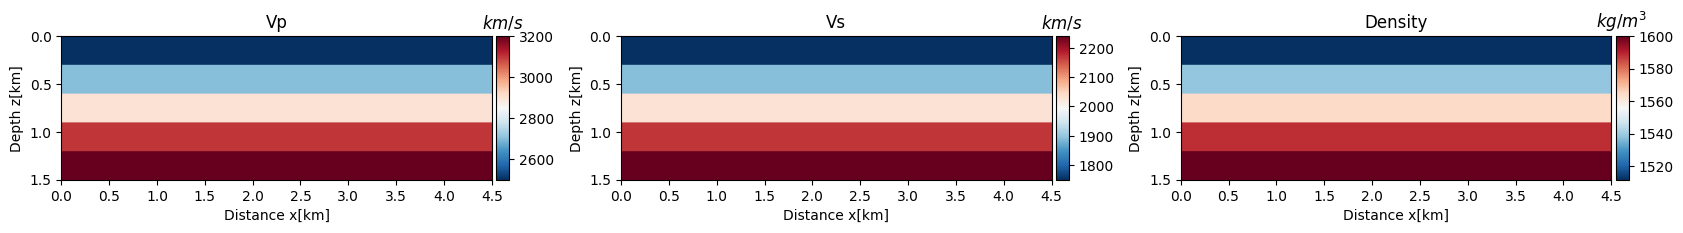

In [97]:
dx = 15
dz = 15

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vp")
im = ax.imshow(vp_tensor.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')


ax = fig.add_subplot(gs[0, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vs")
im = ax.imshow(vs_tensor.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')

ax = fig.add_subplot(gs[0, 2])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Density")
im = ax.imshow(rho_tensor.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$kg/m^3$')

plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=-0.8)

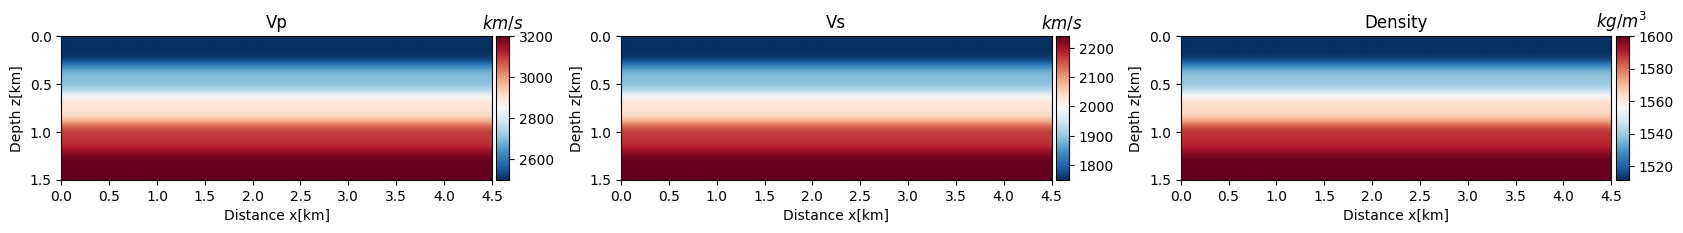

In [98]:
from scipy.ndimage import gaussian_filter
vp_initial = torch.as_tensor(gaussian_filter(vp_tensor.cpu().clone().detach().numpy(), sigma=4)).to(device)
vs_initial = torch.as_tensor(gaussian_filter(vs_tensor.cpu().clone().detach().numpy(), sigma=4)).to(device)
rho_initial = torch.as_tensor(gaussian_filter(rho_tensor.cpu().clone().detach().numpy(), sigma=4)).to(device)

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vp")
im = ax.imshow(vp_initial.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')


ax = fig.add_subplot(gs[0, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vs")
im = ax.imshow(vs_initial.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')

ax = fig.add_subplot(gs[0, 2])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Density")
im = ax.imshow(rho_initial.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$kg/m^3$')


plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=-0.8)

In [99]:
from rnn_fd_elastic2_free_surface import rnn2D
from generator import wGenerator
sample_interval = 30
freeSurface = False                                                      # free surface option for forward modeling
npad = 30                                                               # velocity padding in grid points
freq = 8.0                                                             # dominant frequency of wavelet in Hz
dt = 0.002                                                             # time samling interval, fixed for all shots gathers
nt = 800                                                                # number of samples in time
nv = 1  

xs = np.arange(2,nx,30,dtype=np.int32) # source x-coordinate
zs = np.ones(xs.shape, dtype=np.int32)*3 # source z-coordinate

xr = np.arange(0,nx, 1, dtype=np.int32) # receiver x-coordinate
zr = np.ones(xr.shape, dtype=np.int32) # receiver z-coordinate

t = dt * torch.arange(0, nt, dtype=torch.float32)                       # create time vector
wavelet = wGenerator(t, freq).ricker().to(device)*10000000              # generate wavelet

vp_tensor = torch.reshape(vp_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)
vs_tensor = torch.reshape(vs_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)
rho_tensor = torch.reshape(rho_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)

forward_rnn = rnn2D(nz, nx, zs, xs, zr, xr, dz, dt, 
                    npad=npad, order=2, vmax=vp_tensor.max(), 
                    freeSurface=True, 
                    dtype=torch.float32, 
                    device=device).to(device)

# forward modeling
vx_save, vz_save, \
txx_save, tzz_save, txz_save, \
segment_ytPred_x1,segment_ytPred_z1,avg_regularizer,\
vp_tensor_out,vs_tensor_out,rho_tensor_out = \
forward_rnn(vp_tensor=vp_tensor.to(device),\
            vs_tensor=vs_tensor.to(device),\
            rho_tensor=rho_tensor.to(device),\
            segment_wavelet=wavelet)




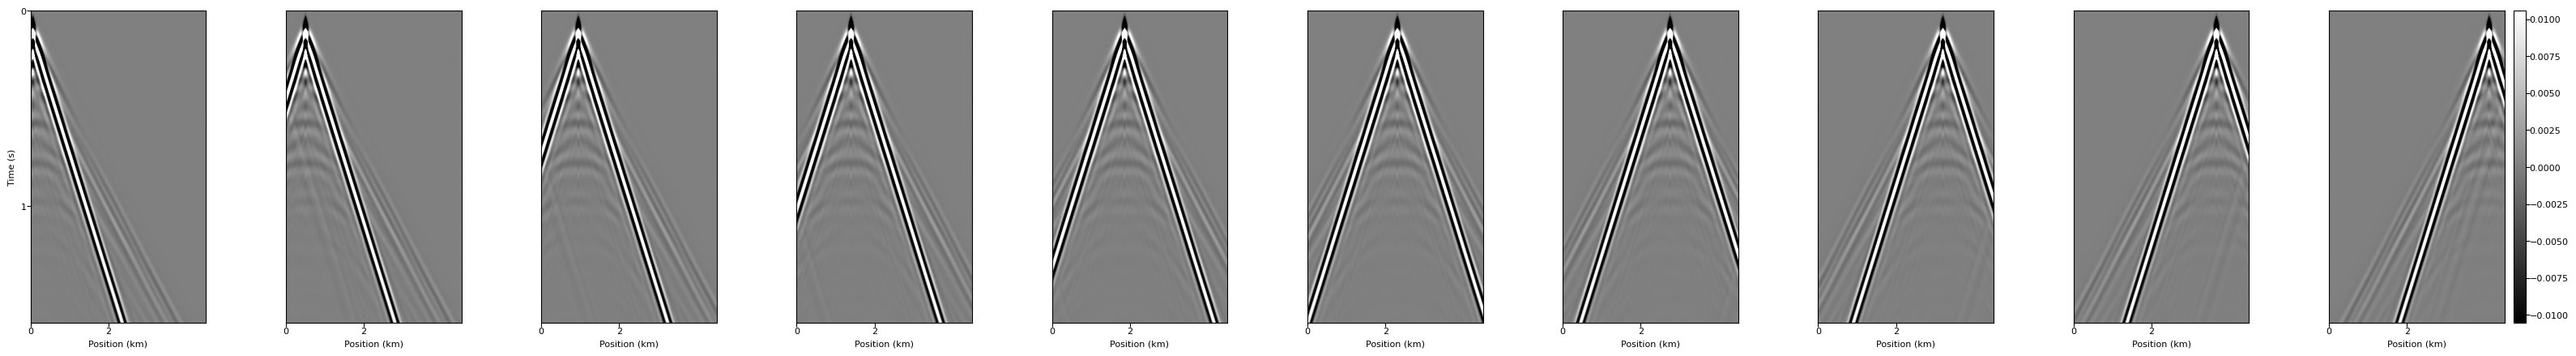

In [100]:
fig=plt.figure(figsize=(40, 5))
imagesc(fig,
        segment_ytPred_z1.cpu().numpy().reshape(-1, int(len(xs)), len(t), len(xr)),
        vmin=-segment_ytPred_z1.max()/30,
        vmax=segment_ytPred_z1.max()/30,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=5, #5
        nRows_nCols=(1,len(xs)),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=8,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')

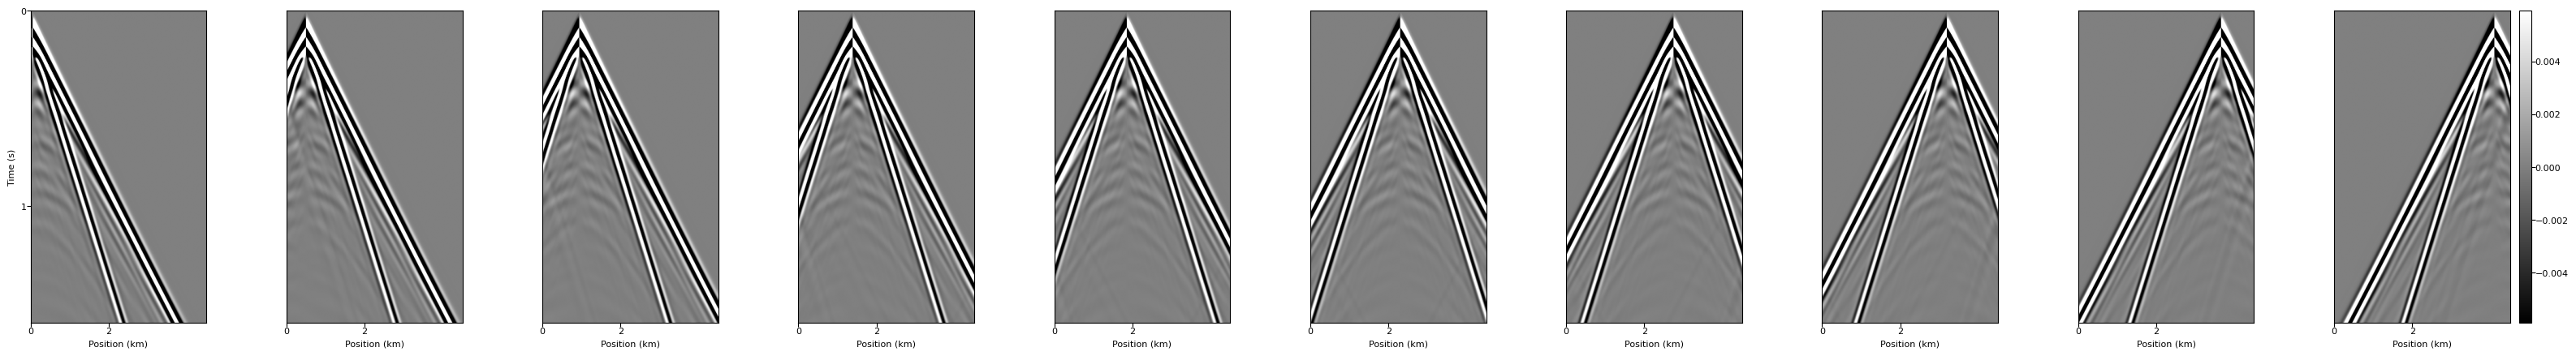

In [101]:
fig=plt.figure(figsize=(40, 5))
imagesc(fig,
        segment_ytPred_x1.cpu().numpy().reshape(-1, int(len(xs)), len(t), len(xr)),
        vmin=-segment_ytPred_x1.max()/30,
        vmax=segment_ytPred_x1.max()/30,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=5, #5
        nRows_nCols=(1,len(xs)),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=8,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')

In [102]:
from rnn_fd_elastic2 import rnn2D
forward_rnn = rnn2D(nz, nx, zs, xs, zr, xr, dz, dt, 
                    npad=npad, order=2, vmax=vp_tensor.max(), 
                    freeSurface=False, 
                    dtype=torch.float32, 
                    device=device).to(device)

# forward modeling
vx_save, vz_save, \
txx_save, tzz_save, txz_save, \
segment_ytPred_x2,segment_ytPred_z2,avg_regularizer,\
vp_tensor_out,vs_tensor_out,rho_tensor_out = \
forward_rnn(vp_tensor=vp_tensor.to(device),\
            vs_tensor=vs_tensor.to(device),\
            rho_tensor=rho_tensor.to(device),\
            segment_wavelet=wavelet)




torch.Size([10, 800, 300])


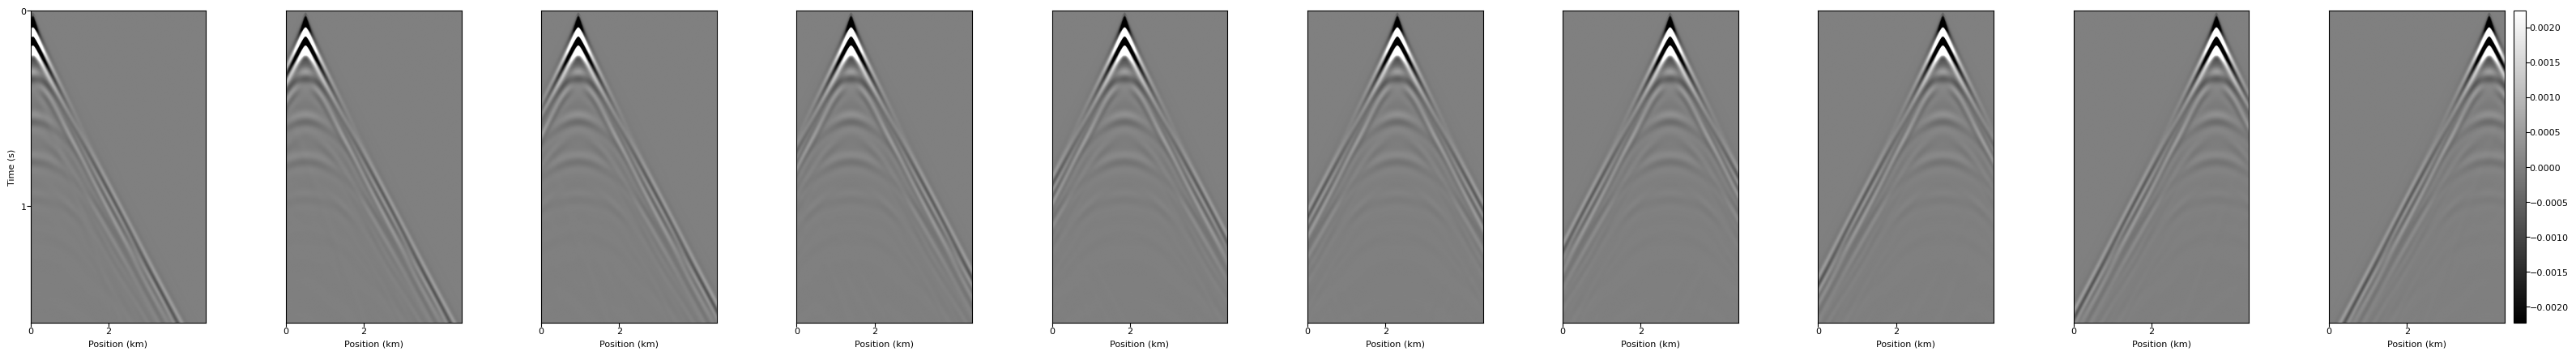

In [103]:
print(segment_ytPred_z2.shape)
fig=plt.figure(figsize=(40, 5))
imagesc(fig,
        segment_ytPred_z2.cpu().numpy().reshape(-1, int(len(xs)), len(t), len(xr)),
        vmin=-segment_ytPred_z2.max()/30,
        vmax=segment_ytPred_z2.max()/30,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=5, #5
        nRows_nCols=(1,len(xs)),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=8,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')

torch.Size([10, 800, 300])


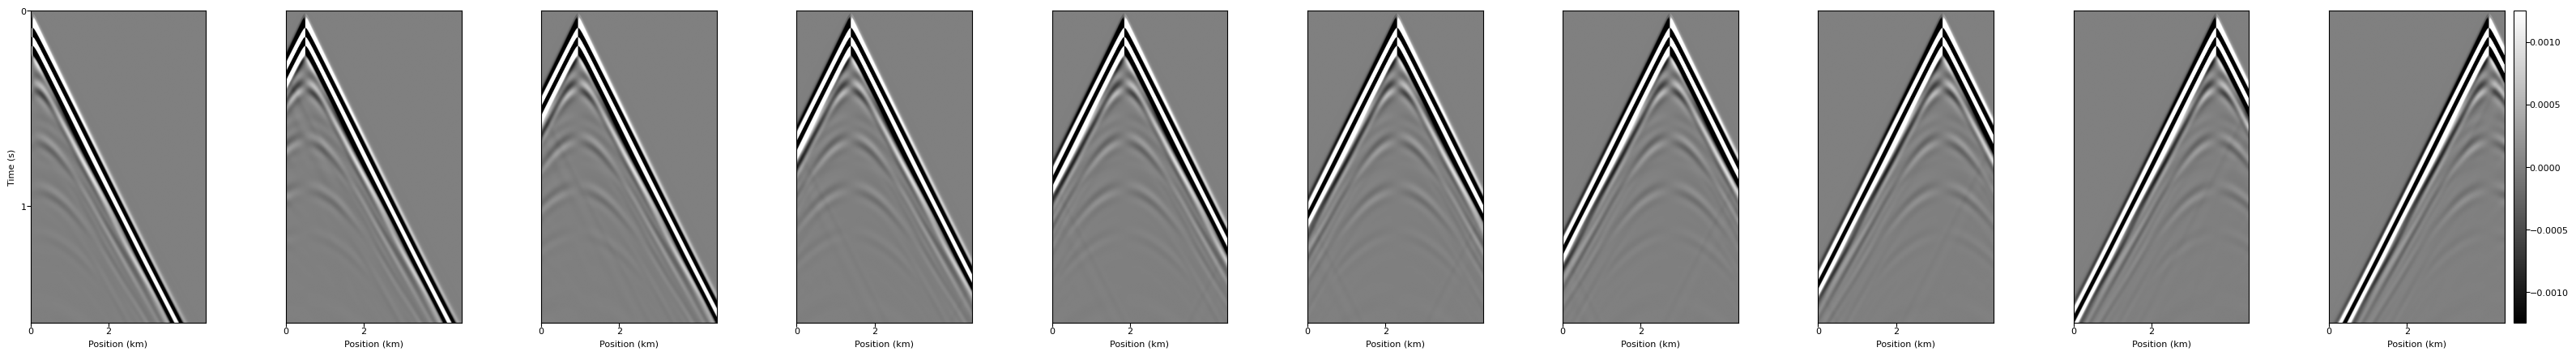

In [104]:
print(segment_ytPred_x2.shape)
fig=plt.figure(figsize=(40, 5))
imagesc(fig,
        segment_ytPred_x2.cpu().numpy().reshape(-1, int(len(xs)), len(t), len(xr)),
        vmin=-segment_ytPred_x2.max()/30,
        vmax=segment_ytPred_x2.max()/30,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=5, #5
        nRows_nCols=(1,len(xs)),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=8,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')

In [105]:
res= segment_ytPred_z2 -segment_ytPred_z1

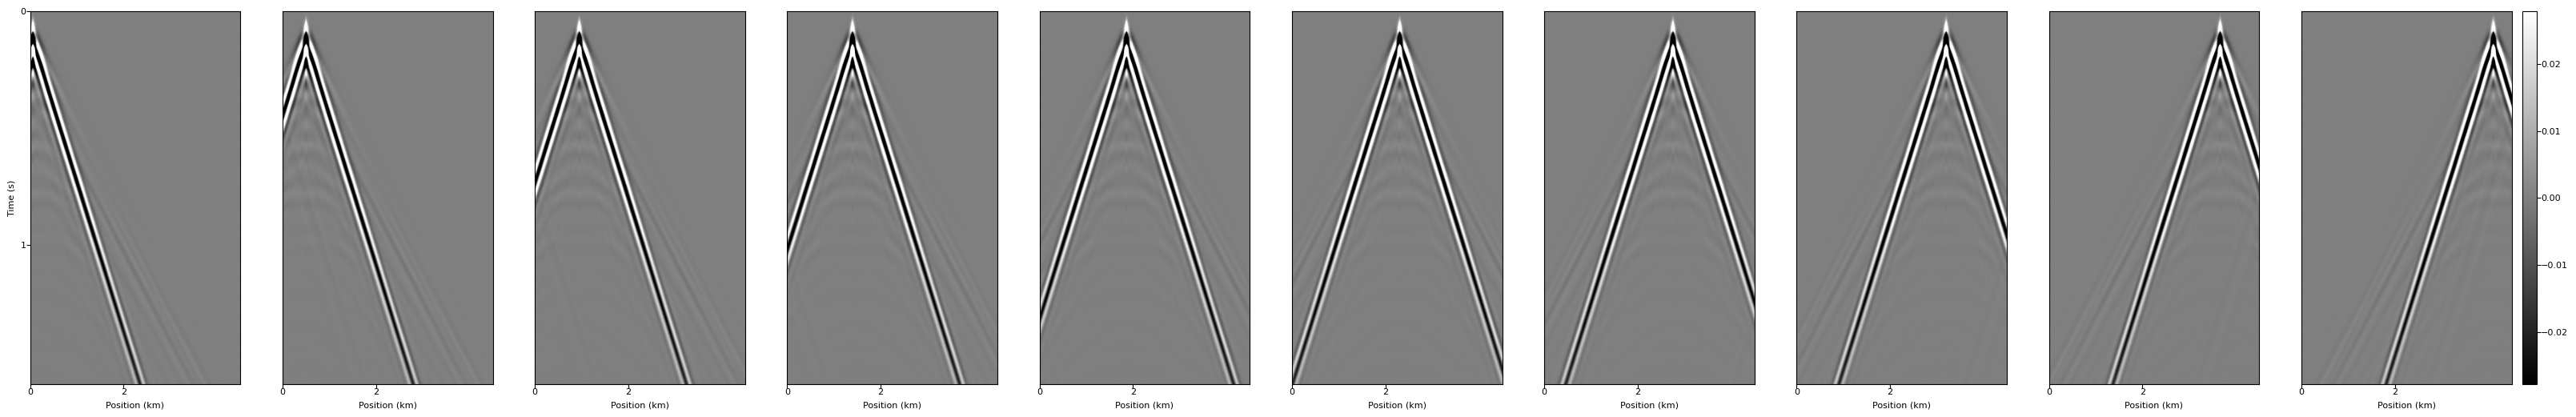

In [106]:
fig=plt.figure(figsize=(40, 10))
imagesc(fig,
        res.cpu().numpy().reshape(-1, int(len(xs)), len(t), len(xr)),
        vmin=-res.max()/10,
        vmax=res.max()/10,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=5, #5
        nRows_nCols=(1,len(xs)),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=8,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')